## Importing libraries

In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew

from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import roc_curve

from warnings import filterwarnings
filterwarnings('ignore')
print("All done")

All done


## Reading the data

In [174]:
data = pd.read_csv('churn_prediction.csv')

In [209]:
df = data.copy()

In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28382 entries, 0 to 28381
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_id                     28382 non-null  int64  
 1   vintage                         28382 non-null  int64  
 2   age                             28382 non-null  int64  
 3   gender                          27857 non-null  object 
 4   dependents                      25919 non-null  float64
 5   occupation                      28302 non-null  object 
 6   city                            27579 non-null  float64
 7   customer_nw_category            28382 non-null  int64  
 8   branch_code                     28382 non-null  int64  
 9   days_since_last_transaction     25159 non-null  float64
 10  current_balance                 28382 non-null  float64
 11  previous_month_end_balance      28382 non-null  float64
 12  average_monthly_balance_prevQ   

### Meaning of some categiories

<b>vintage</b> - Vintage of the customer with the bank in number of days

<b>dependents</b> - Number of dependents

<b>customer_nw_category</b> - Net worth of customer (3:Low 2:Medium 1:High)

<b>branch_code</b> - Branch Code for customer account

<b>days_since_last_transaction</b> - No of Days Since Last Credit in Last 1 year

<b>average_monthly_balance_prevQ</b> - Average monthly balances (AMB) in Previous Quarter

<b>average_monthly_balance_prevQ2</b> - Average monthly balances (AMB) in previous to previous quarter

<b>churn</b> - Average balance of customer falls below minimum balance in the next quarter (1/0)


In [211]:
df.shape

(28382, 21)

In [212]:
df.head(7)

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,...,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
0,1,3135,66,Male,0.0,self_employed,187.0,2,755,224.0,...,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0
1,2,310,35,Male,0.0,self_employed,NaN,2,3214,60.0,...,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0
2,4,2356,31,Male,0.0,salaried,146.0,2,41,NaN,...,5815.29,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0
3,5,478,90,NaN,NaN,self_employed,1020.0,2,582,147.0,...,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1
4,6,2531,42,Male,2.0,self_employed,1494.0,3,388,58.0,...,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1
5,7,263,42,Female,0.0,self_employed,1096.0,2,1666,60.0,...,16059.34,15211.29,13798.82,0.36,0.36,857.50,286.07,15719.44,15349.75,0
6,8,5922,72,Male,0.0,retired,1020.0,1,1,98.0,...,7714.19,7859.74,11232.37,0.64,0.64,1299.64,439.26,7076.06,7755.98,0


## Missing values

In [213]:
df.isnull().sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction       3223
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
dtype: int64

Let's analyze every column that contains Null values

### Gender

In [214]:
df.gender.value_counts()

Male      16548
Female    11309
Name: gender, dtype: int64

We cannot say whether missing customer is male or fmale with the information that we have. Let's encode gender column and assign -1 to the missing rows

In [215]:
df = df.replace({'gender': {'Male': 1, 'Female': 0}})
df.gender = df.gender.fillna(-1)

### Dependents

In [216]:
df.dependents.value_counts()

0.0     21435
2.0      2150
1.0      1395
3.0       701
4.0       179
5.0        41
6.0         8
7.0         3
36.0        1
52.0        1
25.0        1
9.0         1
50.0        1
32.0        1
8.0         1
Name: dependents, dtype: int64

Filling missing values with 0 as most of the customers have 0 dependents

In [217]:
df.dependents = df.dependents.fillna(0)

### Occupation

In [218]:
df.occupation.value_counts()

self_employed    17476
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64

Again we can fill nissing values with the most common category

In [219]:
df.occupation = df.occupation.fillna('self_employed')

### City

In [220]:
df.city.value_counts()

1020.0    3479
1096.0    2016
409.0     1334
146.0     1291
834.0     1138
          ... 
629.0        1
527.0        1
1212.0       1
530.0        1
70.0         1
Name: city, Length: 1604, dtype: int64

Same stategy can be done for the city column

In [221]:
df.city = df.city.fillna(1020)

### Days since last transaction

In [222]:
df.days_since_last_transaction.value_counts()

0.0      1672
3.0       831
14.0      654
4.0       632
6.0       596
         ... 
170.0       1
218.0       1
334.0       1
288.0       1
321.0       1
Name: days_since_last_transaction, Length: 360, dtype: int64

In [223]:
# df = df[df.days_since_last_transaction.notna()]
df['days_since_last_transaction'] = df['days_since_last_transaction'].fillna(999)

In [224]:
print('Total null values: %d' % df.isnull().sum().sum())

Total null values: 0


## EDA

In [19]:
plt.style.use('seaborn')

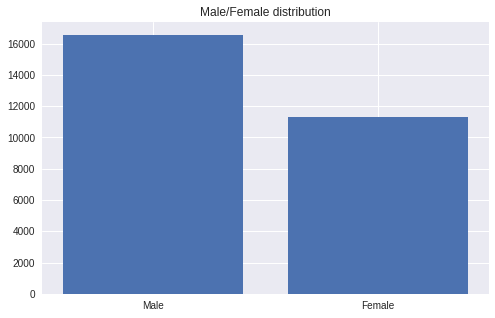

In [20]:
plt.figure(figsize=(8,5))
plt.bar(data.gender.value_counts().index, data.gender.value_counts().values)
plt.title('Male/Female distribution')
plt.show()

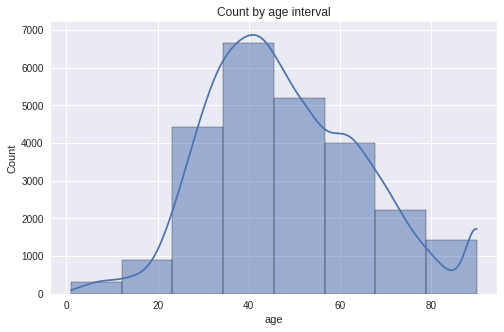

In [21]:
plt.figure(figsize=(8,5))
sns.histplot(df.age, bins=8, kde=True)
plt.title('Count by age interval')
plt.show()

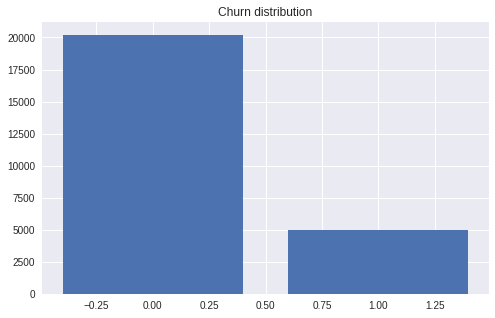

In [22]:
plt.figure(figsize=(8,5))
plt.bar(df.churn.value_counts().index, df.churn.value_counts().values)
plt.title('Churn distribution')
plt.show()

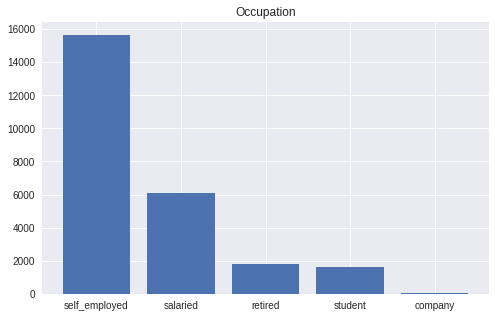

In [23]:
plt.figure(figsize=(8,5))
plt.bar(df.occupation.value_counts().index, df.occupation.value_counts().values)
plt.title('Occupation')
plt.show()

We can see significan difference for different occupations

In [24]:
most_frequent = df.vintage.value_counts()[:20].index
for i in most_frequent:
    print(f'Vintage {i} - {Counter(df[df.vintage==i].churn.values)}')

Vintage 1997 - Counter({0: 18, 1: 3})
Vintage 1432 - Counter({0: 17, 1: 3})
Vintage 403 - Counter({0: 16, 1: 4})
Vintage 287 - Counter({0: 13, 1: 6})
Vintage 1718 - Counter({0: 16, 1: 3})
Vintage 984 - Counter({0: 13, 1: 4})
Vintage 1400 - Counter({0: 13, 1: 4})
Vintage 1394 - Counter({0: 14, 1: 3})
Vintage 1454 - Counter({0: 17})
Vintage 1411 - Counter({0: 10, 1: 7})
Vintage 1460 - Counter({0: 13, 1: 4})
Vintage 775 - Counter({0: 11, 1: 6})
Vintage 1557 - Counter({0: 13, 1: 3})
Vintage 625 - Counter({0: 14, 1: 2})
Vintage 754 - Counter({0: 11, 1: 5})
Vintage 318 - Counter({0: 9, 1: 7})
Vintage 290 - Counter({0: 14, 1: 2})
Vintage 1993 - Counter({0: 12, 1: 4})
Vintage 2285 - Counter({0: 9, 1: 7})
Vintage 606 - Counter({0: 15, 1: 1})


For the most frequent vintage values we can mostly see non-churning customers

In [29]:
df.columns

Index(['customer_id', 'vintage', 'age', 'gender', 'dependents', 'occupation',
       'city', 'customer_nw_category', 'branch_code',
       'days_since_last_transaction', 'current_balance',
       'previous_month_end_balance', 'average_monthly_balance_prevQ',
       'average_monthly_balance_prevQ2', 'current_month_credit',
       'previous_month_credit', 'current_month_debit', 'previous_month_debit',
       'current_month_balance', 'previous_month_balance', 'churn'],
      dtype='object')

In [36]:
df.head(5)

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,...,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
0,1,3135,66,1.0,0.0,self_employed,187.0,2,755,224.0,...,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0
1,2,310,35,1.0,0.0,self_employed,1020.0,2,3214,60.0,...,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0
3,5,478,90,-1.0,0.0,self_employed,1020.0,2,582,147.0,...,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1
4,6,2531,42,1.0,2.0,self_employed,1494.0,3,388,58.0,...,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1
5,7,263,42,0.0,0.0,self_employed,1096.0,2,1666,60.0,...,16059.34,15211.29,13798.82,0.36,0.36,857.50,286.07,15719.44,15349.75,0


In [37]:
cols = ['vintage', 'age', 'days_since_last_transaction', 'current_balance',
       'previous_month_end_balance', 'average_monthly_balance_prevQ', 'average_monthly_balance_prevQ2',
       'current_month_credit', 'previous_month_credit', 'current_month_debit', 'previous_month_debit', 
       'current_month_balance', 'previous_month_balance']

In [38]:
len(cols)

13

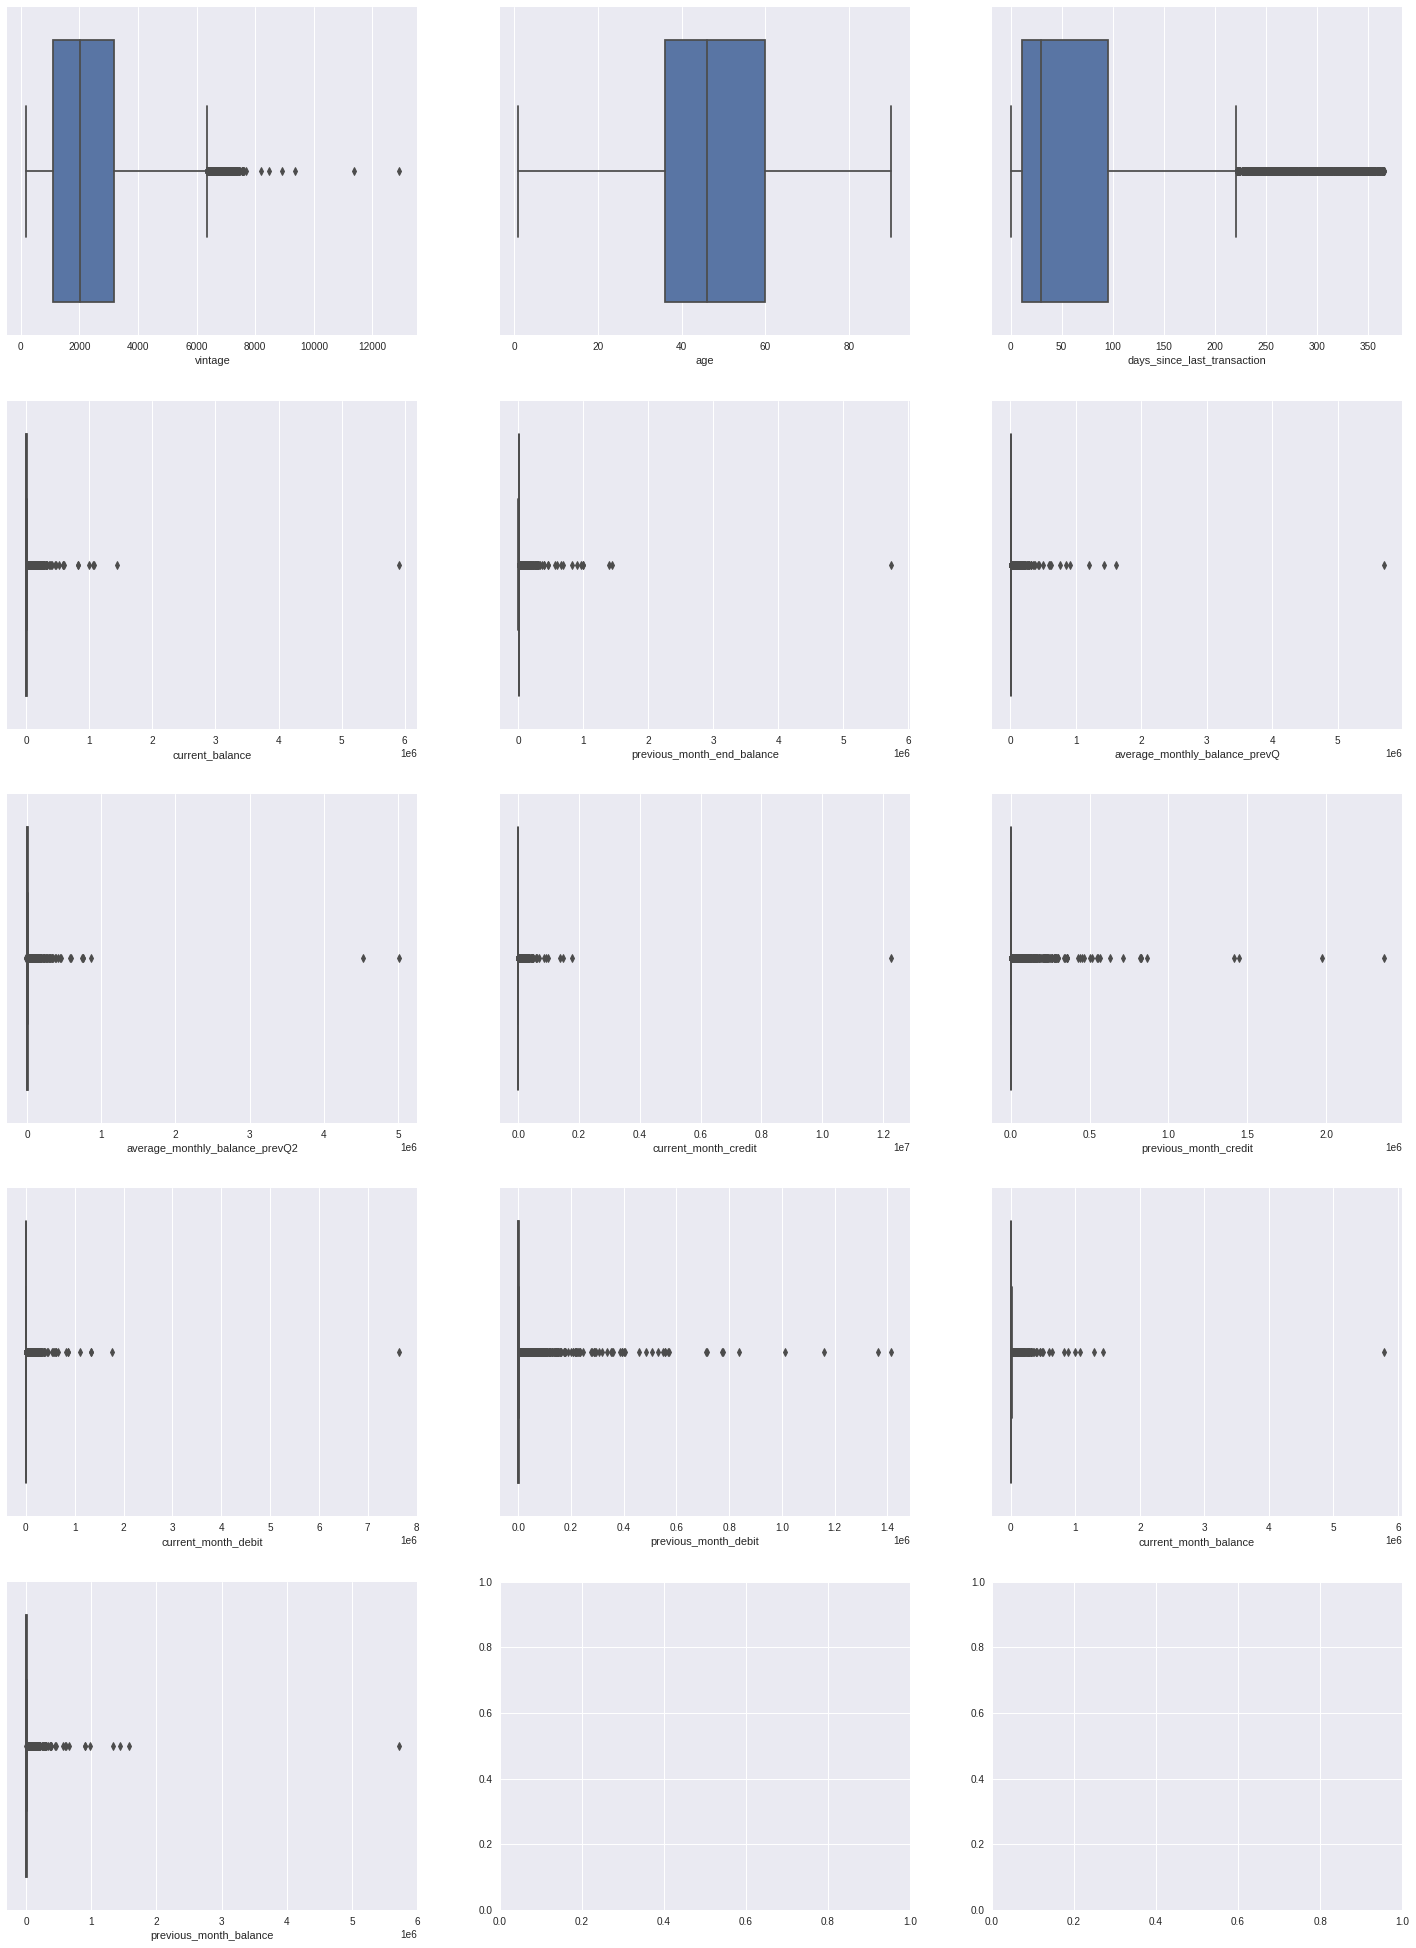

In [55]:
fig, ax = plt.subplots(5, 3, figsize=(25, 35))
row, col = 0, 0

for i in range(len(cols)):
    sns.boxplot(df[cols[i]], ax=ax[row][col])
    col+=1
    if col==3:
        row+=1
        col=0

We can see a lot of outliers in different columns.

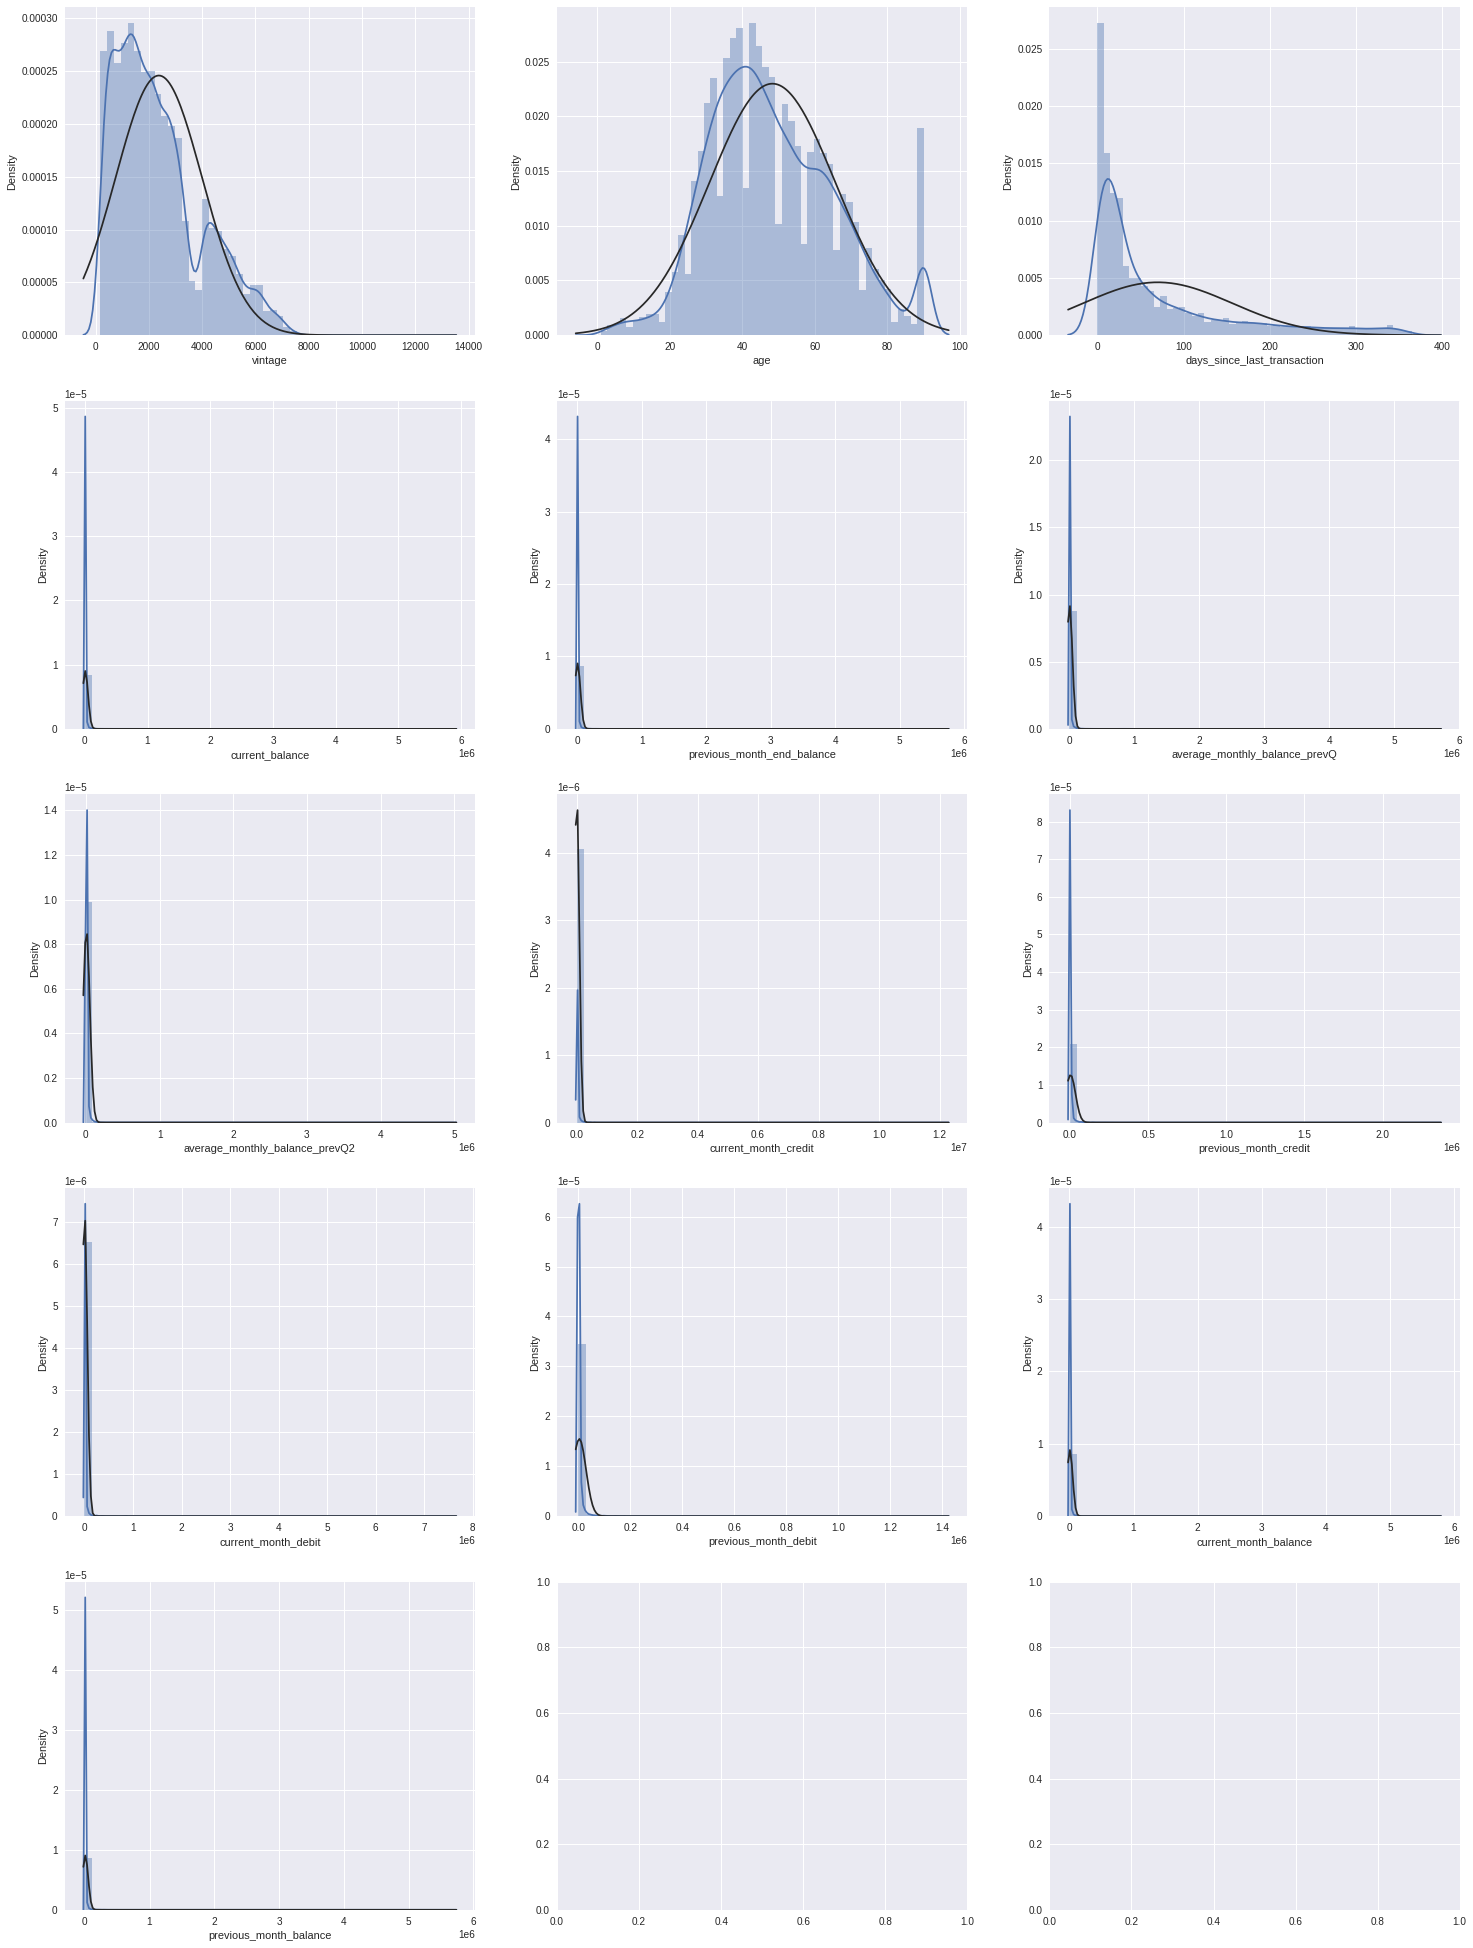

In [63]:
fig, ax = plt.subplots(5, 3, figsize=(25, 35))
row, col = 0, 0

for i in range(len(cols)):
    sns.distplot(df[cols[i]], fit=norm, ax=ax[row][col])
    col+=1
    if col==3:
        row+=1
        col=0

Also, most columns contain skewed distributions.

## Encoding 

Before building model we encode categorical columns to numerical

In [225]:
# encoded = pd.get_dummies(df)
df = pd.concat([df,pd.get_dummies(df['occupation'],prefix = str('occupation'),prefix_sep='_')],axis = 1)

## Scailing

In [226]:
num_cols = ['customer_nw_category', 'current_balance',
            'previous_month_end_balance', 'average_monthly_balance_prevQ2', 'average_monthly_balance_prevQ',
            'current_month_credit','previous_month_credit', 'current_month_debit', 
            'previous_month_debit','current_month_balance', 'previous_month_balance']

Log Transformation

In [227]:
for i in num_cols:
    df[i] = np.log(df[i] + 17000)

Standard Scailer

In [228]:
std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols).dropna()

In [229]:
df_df_og = df.copy()
df = df.drop(columns = num_cols, axis = 1)
df = df.merge(scaled, left_index=True, right_index=True, how = "left")

In [231]:
y = df.churn

In [232]:
df = df.drop(['churn','customer_id'], axis = 1)

In [233]:
df.head()

,vintage,age,gender,dependents,occupation,city,branch_code,days_since_last_transaction,occupation_company,occupation_retired,...,current_balance,previous_month_end_balance,average_monthly_balance_prevQ2,average_monthly_balance_prevQ,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance
0,3135,66,1.0,0.0,self_employed,187.0,755,224.0,0,0,...,-0.613738,-0.632367,-0.630646,-0.697612,-0.313931,-0.324487,-0.368251,-0.377390,-0.653455,-0.666207
1,310,35,1.0,0.0,self_employed,1020.0,3214,60.0,0,0,...,0.011267,0.446458,0.949414,0.317595,-0.313852,-0.324410,0.640986,-0.355677,0.149440,0.455680
2,2356,31,1.0,0.0,salaried,146.0,41,999.0,0,0,...,-0.209651,0.057975,-0.388637,-0.108263,-0.313841,-0.324400,0.729825,-0.321607,-0.068597,-0.066642
3,478,90,-1.0,0.0,self_employed,1020.0,582,147.0,0,0,...,-0.470836,-0.488530,-0.712855,-0.582976,-0.313872,-0.324429,-0.368193,0.060593,-0.506570,-0.628056
4,2531,42,1.0,2.0,self_employed,1494.0,388,58.0,0,0,...,-0.708214,-0.642441,-0.554058,-0.663399,-0.313902,-0.175104,-0.245463,-0.057927,-0.708257,-0.626732


In [234]:
X = df[['current_month_debit', 'previous_month_debit','current_balance','previous_month_end_balance','vintage'
                 ,'occupation_retired', 'occupation_salaried','occupation_self_employed', 'occupation_student']]

## Train Test Split

In [235]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X ,y, test_size=0.2, random_state=11, stratify = y)

In [236]:
model = LogisticRegression()
model.fit(Xtrain, ytrain)

LogisticRegression()

In [238]:
pred = model.predict_proba(Xtest)[:,1]
pred

array([0.1160447 , 0.08922066, 0.25158717, ..., 0.23807007, 0.31216237,
       0.06753078])

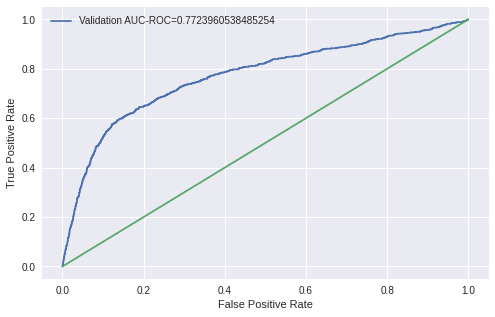

In [243]:
fpr, tpr, _ = roc_curve(ytest, pred) 
auc = roc_auc_score(ytest, pred) 
plt.figure(figsize=(8,5)) 
plt.plot(fpr,tpr,label="Validation AUC-ROC="+str(auc)) 
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc='best') 
plt.show()

In [245]:
pred_val = model.predict(Xtest)

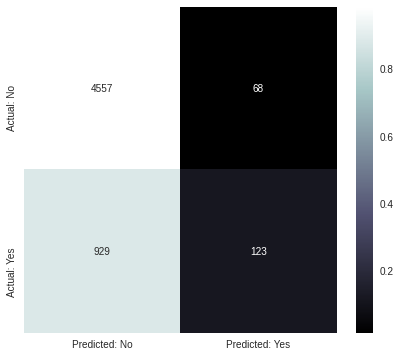

In [246]:
label_preds = pred_val

cm = confusion_matrix(ytest, label_preds)


def plot_confusion_matrix(cm, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=['False','True'], yticklabels=['Actual: No','Actual: Yes'], cmap=cmap)

plot_confusion_matrix(cm, ['No', 'Yes'])